# **Lab 6a - Explainable and Trustworthy AI**


---



**Teaching Assistant**: *Salvatore Greco*

**DISCLAIMER**: *This lab contains examples of offensive language*.

## **Lab 6a:** Introduction to Natural Language Processing (NLP) with HuggingFace

In this lab, you will learn how to **train** NLP classifiers and make **inferences** using the [HuggingFace](https://huggingface.co/docs) library.

Two of the most famous libraries inside HuggingFace are the [Transformers](https://huggingface.co/docs/transformers/index) and [Datasets](https://huggingface.co/docs/datasets/index) libraries.
- [Datasets](https://huggingface.co/docs/datasets/index) provides classes and methods to access and share datasets for NLP, computer vision, and audio tasks.
- [Transformers](https://huggingface.co/docs/transformers/index) provides classes and methods to train and use deep learning models for PyTorch, TensorFlow, and JAX.

The objective of this notebook is to train and use a **binary toxicity prediction classifier**. 


Firstly, you need to install these libraries. Run the next cell to install it (uncomment the lines if you need to insall them).



In [1]:
#!pip install transformers
#!pip install datasets
#!pip install accelerate -U

Run the next cell to import the required libraries for this lab.

In [2]:
# Import the required libraries for this lab
from datasets import load_dataset
import transformers

from collections import Counter

import matplotlib.pyplot as plt

import sklearn
import numpy as np

import os
import torch
from torch import nn

/home/students/s289159/.conda/envs/audio-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Run the following command to check GPU utilization, memory usage, and availability. If the command outputs information about your GPU, it means the GPU is available. In contrast, the command returns an error or no information; it indicates that the GPU might not be available or there is an issue.

Note that a GPU is required to train (fine-tune) transformer models.

In [3]:
!nvidia-smi

Tue May  7 12:17:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000000:D8:00.0 Off |                    0 |
| N/A   40C    P0              24W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---

## **Exercise 1: Fine-tuning BERT for Toxicity prediction**

### BERT Model
In this exercise, you will **fine-tune** a **BERT** model for **toxicity predictions** using the HuggingFace library.

[BERT](https://aclanthology.org/N19-1423.pdf) is a **transformer-encoder** model pre-trained on a large corpus of English data in a self-supervised fashion, using **Masked Language Modeling (MLM)** and **Next Sentence Prediction (NSP)** tasks.

You will fine-tune the original pre-trained weights of the base and uncased version of BERT  (available [here](https://huggingface.co/google-bert/bert-base-uncased)). The base version contains 12 transformer (encoder) layers and with embedding dimensionality 768. The model is uncased, thus it perform lowercasing during tokenization (i.e., it does not discriminate between upper and lower case letters).

You can learn about the BERT architecture from the following links: [blog1](https://jalammar.github.io/illustrated-bert/) and [blog2](https://medium.com/@shaikhrayyan123/a-comprehensive-guide-to-understanding-bert-from-beginners-to-advanced-2379699e2b51).

## Dataset
You will use a dataset ([Jigsaw Toxic Comments](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data)) of publicly available Wikipedia comments annotated for several aspects of toxicity: *toxic*, *severe_toxic*, *obscene*, *threat*, *insult*, *identity_hate*. To simplify the task, and, later, the model's explanation, you will train a **binary model to predict the *toxic* label only**.

### 1.1 Load dataset

Firstly, you will load the dataset using the [load_dataset](https://huggingface.co/docs/datasets/loading) function of the `Datasets` transformers library.

The Transformers library, along with the datasets library, provides many pre-uploaded datasets that you can download with just one line of code using the `load_dataset` function. These datasets range across a variety of domains and tasks, such as text classification, sentiment analysis, machine translation, and many more.

The dataset of Wikipedia comments annotated for toxicity is available on HugginFace [Here](https://huggingface.co/datasets/google/jigsaw_toxicity_pred).<br> However, in this particular case, you must also have the files in a local folder and specify that folder in the `load_dataset` function.

Make sure you have a local folder with the following tree structure:
```
.
└── jigsaw_toxicity_pred/
    ├── train.csv
    ├── test.csv
    └── test_labels.csv
```

You can download the files from [Kaggle](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data), or you can use the data zip file for this lab.

In [4]:
#!ls

Uncomment the next line if you need to unzip the file.

In [5]:
#!unzip -o jigsaw_toxicity_pred.zip

In [6]:
# Load the jigsaw toxicity prediction dataset
dataset = load_dataset("google/jigsaw_toxicity_pred", data_dir="jigsaw_toxicity_pred")

Using custom data configuration default-data_dir=jigsaw_toxicity_pred
Reusing dataset jigsaw_toxicity_pred (/home/students/s289159/.cache/huggingface/datasets/google___jigsaw_toxicity_pred/default-data_dir=jigsaw_toxicity_pred/1.1.0/9cf096ac4341c35839bc8a9f6a19d93e18e5ad3d84cf05f690d2bc6f7384af85)
100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


In [7]:
# Dictionary that maps the label id to the label name
id2label = {0: "Non-Toxic", 1: "Toxic"} 

# Dictionary that maps the label name to the label id
label2id = {"Non-Toxic": 0, "Toxic": 1}

label_names = ['Non-Toxic', 'Toxic']

### 1.2 Dataset exploration

The dataset contains 159,571 training and 63,978 test samples. 

Each sample contains the input comment `comment_text` and all the toxicity related labels: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. <br> However, you will only use the `toxic` label.

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 159571
    })
    test: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 63978
    })
})

In the next cells you will explore some samles of the dataset. Feel free to change the `text_id`.

In [9]:
text_id = 5000

In [10]:
# Print the comment in the position equal to `text_id` 
print(dataset["train"]['comment_text'][text_id])

hay bitch 

thank you kindly for your advice on my vandalism but if your the dick who removed the thing abouth Berties make up costs Thats true... so ah FUCK  YOU


In [11]:
# Print the label identifier and name in the position equal to `text_id` 
print(f"Label ID: {dataset['train']['toxic'][text_id]}")
print(f"Label name: {id2label[dataset['train']['toxic'][text_id]]}")

Label ID: 1
Label name: Toxic


The next two cells **count** and **plot** the number of `non-toxic` and `toxic` samples in the training and test set 

In [12]:
# Count the number of samples for each label
print("Number of samples for each label in the Training set:")
for label_id, count in Counter(dataset['train']['toxic']).items():
    print(f"Label: {id2label[label_id]}, Count: {count}")

print("\nNumber of samples for each label in the Test set:")
for label_id, count in Counter(dataset['test']['toxic']).items():
    print(f"Label: {id2label[label_id]}, Count: {count}")

Number of samples for each label in the Training set:
Label: Non-Toxic, Count: 144277
Label: Toxic, Count: 15294

Number of samples for each label in the Test set:
Label: Non-Toxic, Count: 57888
Label: Toxic, Count: 6090


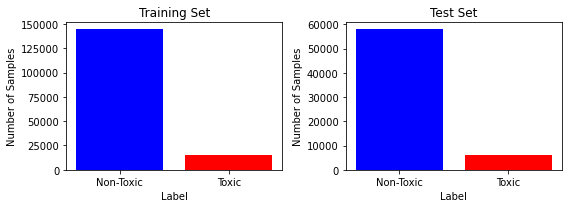

In [13]:
# Extract the 'toxic' column from the training set
train_toxic_labels = dataset['train']['toxic']
test_toxic_labels = dataset['test']['toxic']

# Count the number of samples for each label in the training set
train_label_counts = Counter(train_toxic_labels)
test_label_counts = Counter(test_toxic_labels)

# Plot the bar plots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot for training set
axes[0].bar(label_names, train_label_counts.values(), color=['blue', 'red'])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Training Set')

# Plot for test set
axes[1].bar(label_names, test_label_counts.values(), color=['blue', 'red'])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Test Set')

plt.tight_layout()
plt.show()

As you can see from the previous cells, the dataset is highly imbalanced (as expected). Indeed, `non-toxic` comments are one order of magnitude more than `toxic` ones. Therefore, you will use inversely proprotional **class weights** in the loss function.

Run the next cell to compute the inversely proportional class weights.<br> Since you will use it in the loss function, you must convert it to a PyTorch tensor `class_weights`.

In [14]:
# Calculate class frequencies in the training data
class_frequencies = np.bincount(train_toxic_labels)
total_samples = len(train_toxic_labels)

# Calculate class frequencies in the training data
class_frequencies = np.bincount(train_toxic_labels)
total_samples = len(train_toxic_labels)

# Calculate class weights based on class frequencies, ensuring they sum up to 1
class_weights = total_samples / (class_frequencies * len(class_frequencies))
class_weights /= class_weights.sum()  # Normalize to ensure they sum to 1

# Convert class_weights to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("class weights", class_weights)

class weights tensor([0.0958, 0.9042])


### 1.3 Load the model and the tokenizer

The next cell loads the **model** and **tokenizer** using [AutoCLasses](https://huggingface.co/docs/transformers/model_doc/auto). 
AutoClasses can automatically retrieves the relevant model given the name or path to the pre-trained weights, config, and vocabulary. 
Specifically, the AutoClasses automatically retrive the architecture you want to use from the name or the path of the pretrained model you are supplying to the `from_pretrained()` method.

You will use [AutoTokenizer](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autotokenizer) to automatically download the tokenizer.
For the model, you use [AutoModelForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification) since you will be performing a sentence classification task. <br> You can see all the AutoModels [here](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodels).

For the tokenizer, you have to specify `'do_lower_case' = True` to lowercase the input when tokenizing.

Notice that you are downloading the **pre-trained weights** of BERT (i.e., pre-trained for MLM and NSP on huge corpora). This model already has a lot of prior knowledge and understanding of general English. You will then fine-tune the pre-trained model to your domain-specific data to adapt this broad understanding to your specific task (i.e., toxicity predictions). This is much more effective than training a model from scratch.

In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=len(id2label),
                                                           label2id=label2id,
                                                           id2label=id2label)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Alternatively, if you would not have wanted to use AutoModels, the code would be as follows.

```python
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "bert-base-uncased"

# Use BertTokenizer specific for the "bert-base-uncased" model
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

# Use BertForSequenceClassification specific for the "bert-base-uncased" model
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    label2id=label2id,
    id2label=id2label
)

```

### 1.4 Tokenize the training and test datasets
The main pre-processing steps in NLP consist of splitting the input sentences into words, padding sentences to make sure they have a similar length, and truncating sequences longer than the max sequence length. 


#### **Subword-based tokenization**
**Sub-words** tokenization tries to reduce i) the vocabulary size, ii) the number of out-of-vocabulary (OOV) words, and iii) the risk to create different representations of very similar words (e.g., words that differ for just one letter such as *'dog'* and *'dogs'*). 

The **subword-based tokenization** algorithms generally use a **special symbol** to indicate which word is the start of the token and which word is the completion.  For the BERT model, the special symbol is `##`. For isntance, the word `“tokenization”` can be split into `“token”` and `“##ization”` which indicates that `“token”` is the start of the word and `“##ization”` is the completion of the word.

You can learn more about subword tokenization [here](https://towardsdatascience.com/word-subword-and-character-based-tokenization-know-the-difference-ea0976b64e17).

#### **Tokenization with HuggingFace**

You will use the [Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__.max_length) to split the input sentences in into words (i.e., tokens). Remember that transformer models, such as BERT, tokenizer the input sentence into **sub-words** when they are not present as full tokens in the vocabulary. 

For the tokenization, you specify the following parameters:
- ` max_length=256`: It Controls the maximum length in terms of subwords. If left unset or set to None, this will use the predefined model maximum length. In the case of BERT base, the maximum possible length is 512.
- `padding="max_length"`: Padding in tokenization is the process of adding extra tokens to text sequences to make them a uniform length for batch processing. The pad token has identifier equal to 0. This parameter controls how padding is performed. It performs padding to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided. 
- `truncation=True`: Truncation is the process of cutting off text sequences that exceed a specified length, ensuring they fit within a defined token limit. This parameter activates and controls truncation. If truncation is enabled, the tokenizer truncates to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided. This will truncate token by token, removing a token from the longest sequence


You have to first define a tokenization function. Then, you use the `map()` method of datasets to tokenize each sample in the dataset, and you process them in batches instead of one by one. 


In [16]:
def tokenize_function(examples):
    return tokenizer(examples["comment_text"], max_length=256, padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

100%|██████████| 64/64 [00:08<00:00,  7.24ba/s]


In [17]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 159571
    })
    test: Dataset({
        features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
})

In [20]:
print(tokenized_datasets['train']['comment_text'][5000])

hay bitch 

thank you kindly for your advice on my vandalism but if your the dick who removed the thing abouth Berties make up costs Thats true... so ah FUCK  YOU


In [21]:
print(tokenizer.tokenize(tokenized_datasets['train']['comment_text'][5000]))

['hay', 'bitch', 'thank', 'you', 'kindly', 'for', 'your', 'advice', 'on', 'my', 'van', '##dal', '##ism', 'but', 'if', 'your', 'the', 'dick', 'who', 'removed', 'the', 'thing', 'about', '##h', 'bertie', '##s', 'make', 'up', 'costs', 'that', '##s', 'true', '.', '.', '.', 'so', 'ah', 'fuck', 'you']


`input_ids` refers to the **numerical identifiers assigned to each token** in a sequence.<br> `[PAD]` tokens are specified with the id 0. <br>
The first token is the `[CLS]` with id 101. This token can be used to perform the classification.

In [22]:
print(tokenized_datasets['train']['input_ids'][5000])

[101, 10974, 7743, 4067, 2017, 19045, 2005, 2115, 6040, 2006, 2026, 3158, 9305, 2964, 2021, 2065, 2115, 1996, 5980, 2040, 3718, 1996, 2518, 2055, 2232, 20743, 2015, 2191, 2039, 5366, 2008, 2015, 2995, 1012, 1012, 1012, 2061, 6289, 6616, 2017, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


`token_type_ids` (also known as segment IDs) distinguish **different segments of text within a sequence**. For tasks involving pairs of sentences (like question answering or sentence pairs classification), the `token_type_ids` specify which sentence each token belongs to. Typically, tokens from the first sentence are assigned 0, and tokens from the second sentence are assigned 1. This allows BERT to differentiate between multiple segments and understand the relationships between them.
However, in the case of classification, only a single segment is required (i.e., the whole sentence to be classified). 

In [23]:
print(tokenized_datasets['train']['token_type_ids'][5000])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


`attention_mask` indicates which tokens should be attended to and which should be ignored during self-attention. Tokens that are real (not padding) have an attention mask value of `1`, while padding tokens are marked with `0`. This mask ensures that the model doesn't compute attention scores for padded tokens, focusing only on meaningful parts of the input sequence.

In [24]:
print(tokenized_datasets['train']['attention_mask'][5000])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 1.5 Remove unused columns

The following cell removes unused columns to decrease the size of the dataset. Moreover, it renames the `"toxic"` column as `"label"` for clarity and to match the format expected by the model. 

In [25]:
# Drop the specified columns
tokenized_datasets['train'] = tokenized_datasets['train'].remove_columns(['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
tokenized_datasets['test'] = tokenized_datasets['test'].remove_columns(['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

tokenized_datasets['train'] = tokenized_datasets['train'].rename_columns({"toxic": "label"})
tokenized_datasets['test'] = tokenized_datasets['test'].rename_columns({"toxic": "label"})

In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 159571
    })
    test: Dataset({
        features: ['comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
})

### 1.6 Define a function to compute the evaluation metrics

The next cell defines a function, compute_metrics, that calculates key evaluation metrics, including precision, recall, F1 score, and accuracy for a model's predictions. It processes the predicted labels, handles multiple prediction structures, and returns these metrics as a dictionary. Additionally, it prints a classification report for a detailed performance overview.

This function will be used later during training.

In [27]:
def compute_metrics(pred):
    labels = pred.label_ids
    print(pred)
    try:
        preds = pred.predictions.argmax(-1)
    except:
        preds = pred.predictions[0].argmax(-1)
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        labels, preds, average="macro", labels=list(set(labels))
    )
    print(sklearn.metrics.classification_report(labels, preds, digits=4))
    acc = sklearn.metrics.accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

### 1.7 Define the training arguments and loop

The next cell defines the training arguments for the model using the [TrainingArguments](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.TrainingArguments) class. The key settings include:

- **Output Directory**: Specifies the directory for saving checkpoints.
- **Learning Rate**: Sets the learning rate to 2e-5 for model training.
- **Epochs**: Sets the number of training epochs to 3.
- **Batch Sizes**: Defines per-device batch sizes for training and evaluation.
- **Weight Decay**: Adds a weight decay of 0.01 to prevent overfitting.
- **Evaluation and Save Strategies**: Evaluates and saves the model after each epoch.
- **Best Model**: Identifies the best model using the F1 score, and loading it at the end.

In [28]:
from transformers import TrainingArguments

model_dir = "saved_models"

training_args = TrainingArguments(
    output_dir=os.path.join(model_dir, "checkpoint"),
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    greater_is_better=True,
)

This cell defines a CustomTrainer class that extends the [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class from the Transformers library to include a custom loss function. You use it to include the inversionally proportional weights in the loss function due to the imbalanced dataset. However, you can usually just use the default Trainer.

Specifically, the defined loss function `compute_loss` performs the following steps: 
- Receives model input and retrieves the labels.
- Performs a forward pass through the model to generate logits.
- Uses nn. CrossEntropyLoss with class weights to calculate the loss based on the model's predictions and the ground truth.
- Returns the calculated loss alone or along with model outputs if requested.

In [29]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(torch.cuda.current_device()))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

The next cell creates a CustomTrainer instance using the previously defined custom trainer class.<br> The trainer setup combines all relevant components to train, evaluate, and save the best-performing model efficiently using custom metrics and loss functions. 

In [30]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

### 1.8 Model training
Run the `train()` method of the `trainer` to perform the **training**.

In [31]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text. If comment_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/students/s289159/.conda/envs/audio-env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 159571
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 29922


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.252100,0.267203,0.928007,0.829936,0.783510,0.909085
2,0.151500,0.362665,0.915612,0.812009,0.761508,0.913108
3,0.108700,0.490707,0.915174,0.810583,0.760565,0.910148


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text. If comment_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16


              precision    recall  f1-score   support

           0     0.9873    0.9325    0.9591     57888
           1     0.5798    0.8857    0.7008      6090

    accuracy                         0.9280     63978
   macro avg     0.7835    0.9091    0.8299     63978
weighted avg     0.9485    0.9280    0.9345     63978



Saving model checkpoint to saved_models/checkpoint/checkpoint-9974
Configuration saved in saved_models/checkpoint/checkpoint-9974/config.json
Model weights saved in saved_models/checkpoint/checkpoint-9974/pytorch_model.bin
tokenizer config file saved in saved_models/checkpoint/checkpoint-9974/tokenizer_config.json
Special tokens file saved in saved_models/checkpoint/checkpoint-9974/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text. If comment_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16


              precision    recall  f1-score   support

           0     0.9898    0.9162    0.9516     57888
           1     0.5332    0.9100    0.6725      6090

    accuracy                         0.9156     63978
   macro avg     0.7615    0.9131    0.8120     63978
weighted avg     0.9463    0.9156    0.9250     63978



Saving model checkpoint to saved_models/checkpoint/checkpoint-19948
Configuration saved in saved_models/checkpoint/checkpoint-19948/config.json
Model weights saved in saved_models/checkpoint/checkpoint-19948/pytorch_model.bin
tokenizer config file saved in saved_models/checkpoint/checkpoint-19948/tokenizer_config.json
Special tokens file saved in saved_models/checkpoint/checkpoint-19948/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text. If comment_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16


              precision    recall  f1-score   support

           0     0.9891    0.9164    0.9513     57888
           1     0.5320    0.9039    0.6698      6090

    accuracy                         0.9152     63978
   macro avg     0.7606    0.9101    0.8106     63978
weighted avg     0.9456    0.9152    0.9245     63978



Saving model checkpoint to saved_models/checkpoint/checkpoint-29922
Configuration saved in saved_models/checkpoint/checkpoint-29922/config.json
Model weights saved in saved_models/checkpoint/checkpoint-29922/pytorch_model.bin
tokenizer config file saved in saved_models/checkpoint/checkpoint-29922/tokenizer_config.json
Special tokens file saved in saved_models/checkpoint/checkpoint-29922/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from saved_models/checkpoint/checkpoint-9974 (score: 0.8299364228139947).


TrainOutput(global_step=29922, training_loss=0.18763850862094963, metrics={'train_runtime': 8633.6416, 'train_samples_per_second': 55.447, 'train_steps_per_second': 3.466, 'total_flos': 6.297734132227584e+16, 'train_loss': 0.18763850862094963, 'epoch': 3.0})

### 1.9 Model evaluation

Run the next cell to **evaluate** the best model on the test set.

In [32]:
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: comment_text. If comment_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16


              precision    recall  f1-score   support

           0     0.9873    0.9325    0.9591     57888
           1     0.5798    0.8857    0.7008      6090

    accuracy                         0.9280     63978
   macro avg     0.7835    0.9091    0.8299     63978
weighted avg     0.9485    0.9280    0.9345     63978



{'eval_loss': 0.2672027349472046,
 'eval_accuracy': 0.9280065022351434,
 'eval_f1': 0.8299364228139947,
 'eval_precision': 0.7835103226248628,
 'eval_recall': 0.9090850311932401,
 'eval_runtime': 328.8711,
 'eval_samples_per_second': 194.538,
 'eval_steps_per_second': 12.16,
 'epoch': 3.0}

The next cells **save** the weights, tokenizer and configuration of the best fine-tuned model on disk.

In [ ]:
#!mkdir saved_models

In [33]:
# Save model
trainer.save_model("saved_models/best_model/")

Saving model checkpoint to saved_models/best_model/
Configuration saved in saved_models/best_model/config.json
Model weights saved in saved_models/best_model/pytorch_model.bin
tokenizer config file saved in saved_models/best_model/tokenizer_config.json
Special tokens file saved in saved_models/best_model/special_tokens_map.json


## **Exercise 2: Use the model for inference**

Now, you will load the fine-tuned model to make predictions on new texts.

### 2.1 Load the model from disk or hub

You will exploit the AutoModels again to load the fine-tuned model. <br>
You can load the fine-tuned model that you saved on this using the following code:

```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("saved_models/best_model")
model = AutoModelForSequenceClassification.from_pretrained("saved_models/best_model")
```

However, since you may have had trouble training the model given the GPU resource shoes, I uploaded a fine-tuned version of the model to HuggingFace [Model Hub](https://huggingface.co/docs/hub/models-the-hub).
The fine-tuned model is available on HuggingFace Hub at the following url: `"grecosalvatore/binary-toxicity-BERT-xai-course"`.

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("grecosalvatore/binary-toxicity-BERT-xai-course")
model = AutoModelForSequenceClassification.from_pretrained("grecosalvatore/binary-toxicity-BERT-xai-course")

loading file https://huggingface.co/grecosalvatore/binary-toxicity-BERT-xai-course/resolve/main/vocab.txt from cache at /home/students/s289159/.cache/huggingface/transformers/e5d43b2d386e860156c0114600c61ed0e9feb26bae30f318e14ec6de23cb58f2.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/grecosalvatore/binary-toxicity-BERT-xai-course/resolve/main/tokenizer.json from cache at /home/students/s289159/.cache/huggingface/transformers/197677385b6f4dc4e2bb944de4c5bce1857e0b1497d5d430714c74fbc6c181bd.f71e12dcf3314f964e59f54247509b88c99b9eac702db689a9c4bd9444c88904
loading file https://huggingface.co/grecosalvatore/binary-toxicity-BERT-xai-course/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/grecosalvatore/binary-toxicity-BERT-xai-course/resolve/main/special_tokens_map.json from cache at /home/students/s289159/.cache/huggingface/transformers/bf2740924fc589f72a385c1124fa32ab61cf01a89b3a0372215343e5eb0d27c

### 2.2 Make predictions

The easiest way to make predictions on new texts is to use Hugging Face [Pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines), which offer high-level API functions to process data using a specified model.

In [35]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="grecosalvatore/binary-toxicity-BERT-xai-course")

loading configuration file https://huggingface.co/grecosalvatore/binary-toxicity-BERT-xai-course/resolve/main/config.json from cache at /home/students/s289159/.cache/huggingface/transformers/8d225c3b3f0ed4509a3b5567c392bf0734d85bf099d44e4891a866032098492f.cd4bae7b8486cb55bc5d195b2000fbf818e16477049363db9832411966d55f88
Model config BertConfig {
  "_name_or_path": "grecosalvatore/binary-toxicity-BERT-xai-course",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Non-Toxic",
    "1": "Toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Non-Toxic": 0,
    "Toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pos

In [36]:
example_texts = [
    "you are white",
    "you are asian",
    "you are latin",
    "You are black"
]

In [37]:
pipe(example_texts)

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'Non-Toxic', 'score': 0.9957643747329712},
 {'label': 'Non-Toxic', 'score': 0.9985798597335815},
 {'label': 'Non-Toxic', 'score': 0.9994617104530334},
 {'label': 'Toxic', 'score': 0.9810092449188232}]

You can see that by just changing the word related to the **race**, the classifier can have different outputs. Even if it can be subjective whether the previous sentences are offensive or not, the classifier must have **consistent outputs** across different words related to **race**. This can be a possible warning of **bias** learned by the model. This probably happened because many toxic sentences contain the word `"black"` in the training dataset. Thus, the classifiers learned that the word `"black"` usually indicates toxic language.

If you don't want to use pipelines, an alternative is to directly use the pre-trained model's tokenizer and model objects. This gives you more control over the input processing and prediction steps.

In [39]:
# Tokenize the input texts for model inference
inputs = tokenizer(example_texts, padding=True, truncation=True, return_tensors="pt")

# Forward pass through the model to obtain logits
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get predicted class labels (0 for non-toxic, 1 for toxic)
predicted_classes = torch.argmax(probabilities, dim=-1)

# Print predictions with corresponding probabilities
class_names = ["Non-Toxic", "Toxic"]
for text, prob, pred in zip(example_texts, probabilities, predicted_classes):
    class_prob = prob[pred].item()
    print(f"Text: {text}\nPrediction: {class_names[pred]} (Probability: {class_prob:.2f})\n")

Text: you are white
Prediction: Non-Toxic (Probability: 1.00)

Text: you are asian
Prediction: Non-Toxic (Probability: 1.00)

Text: you are latin
Prediction: Non-Toxic (Probability: 1.00)

Text: You are black
Prediction: Toxic (Probability: 0.98)



This approach provides more flexibility and insight into how the predictions are generated. You can preprocess text inputs and inspect the logits and confidence scores more transparently.

Now, you will predict the labels for the test set, and save them to a csv file for the next lab.

In [ ]:
pipe = pipeline("text-classification", model="grecosalvatore/binary-toxicity-BERT-xai-course", return_all_scores=True, truncation=True, device=0)

In [ ]:
test_predictions = pipe(dataset["test"]["comment_text"][:])

In [ ]:
predictions[0]

In [ ]:
predictions_dicts = []
for p in predictions:
    non_toxic_prob = p[0]['score']
    toxic_prob = p[1]['score']
    if toxic_prob >= non_toxic_prob:
        predicted_label = "Toxic"
    else:
        predicted_label = "Non-Toxic"
    predictions_dicts.append({"non_toxic_prob": non_toxic_prob, "toxic_prob": toxic_prob, "pred_label": predicted_label})

In [ ]:
import pandas as pd

df = pd.DataFrame(predictions_dicts)
df.head()

In [ ]:
df.to_csv("jigsaw_toxicity_pred/test_pred.csv")